# FRAUD BANKS

## Personal Code: José Enrique Mejía Gamarra

- [1. DATA SET INFORMATION AND LOAD](#1)
- [2. PRE-PROCESSING](#2)
- [3. SPLIT THE DATA](#3)
- [4. APPLY UNDER-SAMPLING DATA BALANCING](#4)
- [5. DECISION TREE MODEL](#5)
- [6. RANDOM FOREST MODEL](#6)
- [7. NAIVE BAYES MODEL](#7)
- [8. NEURAL NETWORK MODEL](#8)
- [9. ROC Curve](#9)

<a name='1'></a>
## 1. DATA SET INFORMATION AND LOAD

There is a lack of publicly available datasets on financial services and especially in the emerging domain of mobile money transactions. Part of the problem is the inherently private nature of financial transactions, which does not lead to publicly available datasets.

We present a synthetic dataset generated using the simulator called PaySim as an approach to such a problem. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles normal transaction operation and injects malicious behavior to then evaluate the performance of fraud detection methods.

### Attribute information:

Input variables :

1. steep(type) - CASH, CASH, DEBIT, PAYMENT and TRANSFER.

2. amount(amount) - amount of the transaction in local currency.

3. nameOrig - customer who initiated the transaction

4. oldbalanceOrg - initial balance before the transaction.

5. newbalanceOrig - new balance after the transaction

6. nameDest - client who is the recipient of the transaction

7. oldbalanceDest - recipient of the initial balance before the transaction. Note that there is no information for customers starting with M (Merchants).

8. newbalanceDest: new recipient of the balance after the transaction. Note that there is no information for customers starting with M (Merchants).

9. isFlaggedFraud: the business model aims to monitor massive transfers from one account to another and signals illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction.

Output variable:

1. isFraud: these are the transactions performed by fraudulent agents within the simulation. In this specific dataset, the fraudulent behavior of the agents aims at making profit by taking control of the clients' accounts and attempting to empty the funds by transferring them to another account and then withdrawing from the system.

#### You can download the file from: https://drive.google.com/file/d/1IrmYp0eKCr54kDELRUoZU3Dx-Es8pWpR/view?usp=sharing

In [1]:
# Install PyDrive and import the correspond libraries
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create a PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
# Create the full URL
fileDownloaded = drive.CreateFile({'id':'1IrmYp0eKCr54kDELRUoZU3Dx-Es8pWpR'})

In [3]:
# Define the name of the file and you want to load into memory
fileDownloaded.GetContentFile('fraud_banks.csv')

In [4]:
import pandas as pd
# Read the .csv file
bank = pd.read_csv('fraud_banks.csv', delimiter=',' )
# Check the first rows from the dataframe
bank.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


<a name='2'></a>
## 2. PRE-PROCESSING

In [5]:
import warnings
warnings.filterwarnings('ignore')      #Removing warnings in Jupyter notebook

In [6]:
#Eliminate variables that do not contribute information to the model
df_bank = bank.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)
df_bank.head(10)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.00,160296.36,0.0,0.00,0
1,PAYMENT,1864.28,21249.00,19384.72,0.0,0.00,0
2,TRANSFER,181.00,181.00,0.00,0.0,0.00,1
3,CASH_OUT,181.00,181.00,0.00,21182.0,0.00,1
4,PAYMENT,11668.14,41554.00,29885.86,0.0,0.00,0
5,PAYMENT,7817.71,53860.00,46042.29,0.0,0.00,0
6,PAYMENT,7107.77,183195.00,176087.23,0.0,0.00,0
7,PAYMENT,7861.64,176087.23,168225.59,0.0,0.00,0
8,PAYMENT,4024.36,2671.00,0.00,0.0,0.00,0
9,DEBIT,5337.77,41720.00,36382.23,41898.0,40348.79,0


In [7]:
# Missing value analysis
val_loss=df_bank.isnull().sum()                                  #The sum of the missing values for each label (column) is defined.
pd.DataFrame(val_loss, columns=['Missing values'])   #This information is stored in val_loss and for better visualization it is transformed into DataFrame

,Missing values
type,0
amount,0
oldbalanceOrg,0
newbalanceOrig,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [8]:
#Analysis of object types in the DataFrame
from collections import defaultdict                                   #The module 'defaultdict' is imported from the library 'collections'
from sklearn import preprocessing                                     #The 'preprocessing' module is imported from the 'sklearn' library

types = df_bank.columns.to_series().groupby(df_bank.dtypes).groups    #The object types are generated, grouping the variables according to the type of object
types

{int64: ['isFraud'], float64: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], object: ['type']}

In [10]:
import numpy as np
list_text = list(types[np.dtype("object")])        # A list of 'object' type variables is generated
list_text

['type']

In [11]:
d=defaultdict(preprocessing.LabelEncoder)                                                  # We define the function d

fit = df_bank.apply(lambda x: d[x.name].fit(x) if x.name in list_text else x)
df_bank_2 = df_bank.apply(lambda x: d[x.name].transform(x) if x.name in list_text else x)
df_bank_2.head(10)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,3,9839.64,170136.00,160296.36,0.0,0.00,0
1,3,1864.28,21249.00,19384.72,0.0,0.00,0
2,4,181.00,181.00,0.00,0.0,0.00,1
3,1,181.00,181.00,0.00,21182.0,0.00,1
4,3,11668.14,41554.00,29885.86,0.0,0.00,0
5,3,7817.71,53860.00,46042.29,0.0,0.00,0
6,3,7107.77,183195.00,176087.23,0.0,0.00,0
7,3,7861.64,176087.23,168225.59,0.0,0.00,0
8,3,4024.36,2671.00,0.00,0.0,0.00,0
9,2,5337.77,41720.00,36382.23,41898.0,40348.79,0


In [12]:
# How to obtain each class from the variable "type"
class_type=list(d['type'].classes_)

# The corresponding number of each class in the "class_type" list.
label=d['type'].transform(class_type)

pd.DataFrame(label, index=class_type, columns=['CODIFICACIÓN'])

,CODIFICACIÓN
CASH_IN,0
CASH_OUT,1
DEBIT,2
PAYMENT,3
TRANSFER,4


In [13]:
df_bank_2=df_bank_2.replace({'isFraud': {0: "No", 1: "Si"}})
df_bank_2.head(10)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,3,9839.64,170136.00,160296.36,0.0,0.00,No
1,3,1864.28,21249.00,19384.72,0.0,0.00,No
2,4,181.00,181.00,0.00,0.0,0.00,Si
3,1,181.00,181.00,0.00,21182.0,0.00,Si
4,3,11668.14,41554.00,29885.86,0.0,0.00,No
5,3,7817.71,53860.00,46042.29,0.0,0.00,No
6,3,7107.77,183195.00,176087.23,0.0,0.00,No
7,3,7861.64,176087.23,168225.59,0.0,0.00,No
8,3,4024.36,2671.00,0.00,0.0,0.00,No
9,2,5337.77,41720.00,36382.23,41898.0,40348.79,No


<a name='3'></a>
## 3. SPLIT THE DATA

In [14]:
from sklearn.model_selection import train_test_split                                        #Library for assigning training / test data

X,y = df_bank_2.iloc[:, df_bank_2.columns!='isFraud'].values, df_bank_2.iloc[:,-1].values   #Select data 

X_train, X_test, y_train, y_test = train_test_split(X,                                      #Input parameters
                                                    y,                                      #Target values
                                                   test_size=0.3,                           #Represents the percentage to be taken as test data 30%.         
                                                   random_state=2020,                       #Seed
                                                   stratify=y)                              #Stratification variable - For classes

In [15]:
#Test data
x_test= pd.DataFrame(X_test,                                  #Transformed to DataFrame type
                  columns=df_bank_2.columns[:6].tolist())     #The corresponding columns were defined
y_test= pd.DataFrame(y_test,                                  #Transformed to DataFrame type
                  columns=['isFraud'])                        #The corresponding columns were defined
bank_testeo = pd.concat([x_test, y_test], axis=1)             #DataFrames were concatenated
bank_testeo.head(10)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,3.0,10771.51,11855.00,1083.49,0.00,0.00,No
1,1.0,172254.20,0.00,0.00,2597687.49,2769941.69,No
2,3.0,4798.59,5816.22,1017.62,0.00,0.00,No
3,3.0,14148.59,16676.00,2527.41,0.00,0.00,No
4,3.0,1821.34,63834.16,62012.82,0.00,0.00,No
5,3.0,22612.41,0.00,0.00,0.00,0.00,No
6,1.0,128475.52,375382.36,246906.84,326122.96,454598.48,No
7,3.0,20685.45,0.00,0.00,0.00,0.00,No
8,1.0,425623.98,0.00,0.00,1424339.08,1849963.05,No
9,0.0,166689.86,146957.00,313646.86,0.00,0.00,No


In [16]:
#Training data
x_t= pd.DataFrame(X_train,                                  #Transformed to DataFrame type
                  columns=df_bank_2.columns[:6].tolist())   #The corresponding columns were defined
y_t= pd.DataFrame(y_train,                                  #Transformed to DataFrame type
                  columns=['isFraud'])                      #The corresponding columns were defined
bank_entrenamiento = pd.concat([x_t, y_t], axis=1)          #DataFrames were concatenated
bank_entrenamiento.head(10)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,4.0,228574.65,265547.82,36973.17,6669039.96,6897614.60,No
1,0.0,8184.67,22305077.02,22313261.69,2989440.27,2981255.60,No
2,0.0,214870.38,259252.00,474122.38,1667367.19,1452496.81,No
3,3.0,26519.18,52445.00,25925.82,0.00,0.00,No
4,1.0,130777.25,0.00,0.00,143700.54,274477.80,No
5,3.0,14441.79,409240.00,394798.21,0.00,0.00,No
6,0.0,94761.49,128405.99,223167.47,790657.42,695895.93,No
7,3.0,7946.89,51605.00,43658.11,0.00,0.00,No
8,1.0,66180.54,0.00,0.00,6552198.00,6618378.54,No
9,1.0,131764.17,32425.00,0.00,35608.51,167372.69,No


<a name='4'></a>
## 4. APPLY UNDER-SAMPLING DATA BALANCING

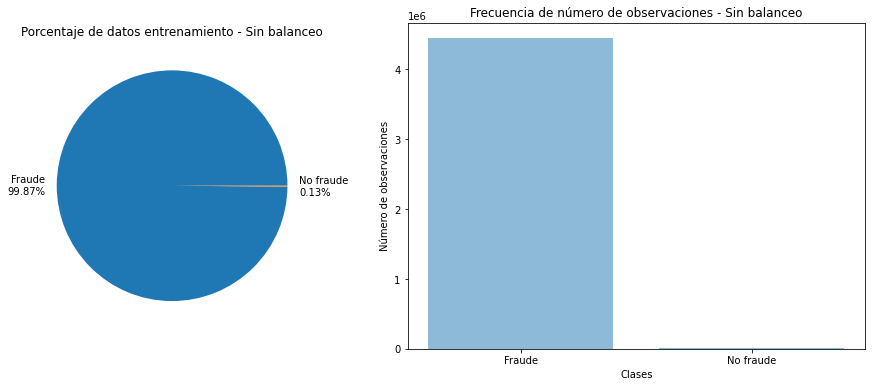

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec                                                   #Gridspec is used to divide the figure into subplots

def bank_balanceo_plot (bank_data, caracteristica):                                      #The function 'bank_balance_plot' is defined
    count_bank = pd.value_counts(bank_data['isFraud'], sort = True)                      #The values in the 'isFraud' column are counted and sorted

    labels = ['Fraude\n' + str(round(count_bank[0]/count_bank.sum()*100,2)) + '%',       #The labels that will appear in the graph are generated.
              'No fraude\n' + str(round(count_bank[1]/count_bank.sum()*100,2)) + '%']

    plt.figure(figsize=(15,6))                                                           #The size of the chart is defined.
    gspec = gridspec.GridSpec(1, 20)                                                     #The area of the chart is divided into 1x20 grids

    left_plot_1=plt.subplot(gspec[0,:7])                                                 #The grids to be used by the left_plot_1 plot are defined.
    right_plot_1=plt.subplot(gspec[0,9:])                                                #The grids to be used by the left_plot_2 plot are defined.

    left_plot_1.pie(count_bank, labels=labels)                                           #A pie chart is generated
    left_plot_1.set_title('Porcentaje de datos entrenamiento'+' - '+caracteristica)      #The title is defined

    right_plot_1.bar(['Fraude', 'No fraude'],count_bank, align='center', alpha=0.5)      #A bar chart is generated
    right_plot_1.set_title("Frecuencia de número de observaciones"+" - "+caracteristica) #The title is defined
    right_plot_1.set_xlabel("Clases")                                                    #Title is defined on x-axis
    right_plot_1.set_ylabel("Número de observaciones");                                  #Title is defined on y-axis

bank_balanceo_plot (bank_entrenamiento, 'Sin balanceo')                                  #The 'bank_balance_plot' function is applied.

In [18]:
from imblearn.over_sampling import RandomOverSampler     #The RandomOverSampler module of the imblearn.over_sampling library is imported.
os =  RandomOverSampler(0.8)

In [20]:
X_train, y_train = bank_entrenamiento.iloc[:, df_bank_2.columns!='isFraud'].values,\
                    bank_entrenamiento.iloc[:,-1].values

X_t_overs, y_t_overs = os.fit_resample(X_train, y_train)                      #Apply it to the training set

#Training data
x_t_overs= pd.DataFrame(X_t_overs, columns=df_bank_2.columns[:6].tolist())  #Transformed to DataFrame type
y_t_overs= pd.DataFrame(y_t_overs, columns=['isFraud'])                     #Transformed to DataFrame type

bank_entrenamiento_2 = pd.concat([x_t_overs, y_t_overs], axis=1)            #DataFrames were concatenated
bank_entrenamiento_2.head(10)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,4.0,228574.65,265547.82,36973.17,6669039.96,6897614.60,No
1,0.0,8184.67,22305077.02,22313261.69,2989440.27,2981255.60,No
2,0.0,214870.38,259252.00,474122.38,1667367.19,1452496.81,No
3,3.0,26519.18,52445.00,25925.82,0.00,0.00,No
4,1.0,130777.25,0.00,0.00,143700.54,274477.80,No
5,3.0,14441.79,409240.00,394798.21,0.00,0.00,No
6,0.0,94761.49,128405.99,223167.47,790657.42,695895.93,No
7,3.0,7946.89,51605.00,43658.11,0.00,0.00,No
8,1.0,66180.54,0.00,0.00,6552198.00,6618378.54,No
9,1.0,131764.17,32425.00,0.00,35608.51,167372.69,No


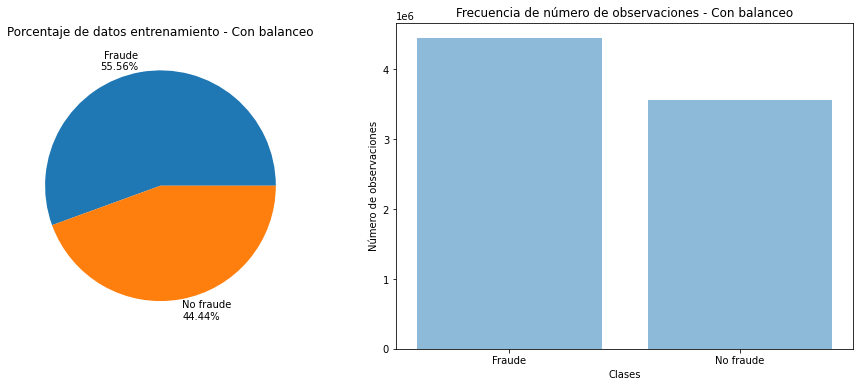

In [21]:
bank_balanceo_plot (bank_entrenamiento_2, 'Con balanceo')  #The 'bank_balance_plot' function is applied

<a name='5'></a>
## 5.	DECISION TREE MODEL

In [24]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.16" 2022-07-19; OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu118.04); OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu118.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpuan4pe4k
  JVM stdout: /tmp/tmpuan4pe4k/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpuan4pe4k/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_unknownUser_ducgzk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [25]:
data_train=h2o.H2OFrame(bank_entrenamiento_2) # Converts a pandas data frame into a h2o data frame

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [26]:
data_test=h2o.H2OFrame(bank_testeo)           # Converts a pandas data frame into a h2o data frame

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [27]:
from h2o.estimators import H2ORandomForestEstimator
# Definition of the Desicion Tree model (Decision Tree)
model_DT = H2ORandomForestEstimator(ntrees=1,           #Number of trees
                                    max_depth=3,        #Maximum tree depth
                                    nfolds=8,           #Number of folds for cross validation
                                   seed=2020)           #Seed

training_columns=data_train.col_names[:-1]           # Predictors of the model
response_column=data_train.col_names[-1]             # Model target

# Training model
model_DT.train(x=training_columns, 
            y=response_column, 
            training_frame=data_train)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1666304462434_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    1                  1                           158                    3            3            3             8             8             8

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.11823475873709466
RMSE: 0.3438528155142759
LogLoss: 0.3806341330334217
Mean Per-Class Error: 0.15982594614059273
AUC: 0.8549407508552787
AUCPR: 0.8783225800209546
Gini: 0.7098815017105573

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.7669278383255005
       No           Si           Error    Rate
-----  -----------  -----------  -------  --------------------
No     1.57314e+06  63643        0.0389   (63643.0/1636786.0)
Si     367512       941436       0.2808   (367512.0/1308948.0)
Total  1.94066e+06  1.00508e+06  0.1464   (431155.0/2945734.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value        idx
---------------------------  -----------  -----------  -----
max f1                       0.766928     0.813678     4
max f2                       0.196155     0.806284     5
max f0point5                 0.766928     0.88327      4
max accuracy                 0.766928     0.853634     4
max precision                0.988047     0.987581     0
max recall                   0.0473207    1            6
max specificity              0.988047     0.996196     0
max absolute_mcc             0.766928     0.71304      4
max min_per_class_accuracy   0.766928     0.719231     4
max mean_per_class_accuracy  0.766928     0.840174     4
max tns                      0.988047     1.63056e+06  0
max fns                      0.988047     813859       0
max fps                      0            1.63679e+06  7
max tps                      0.0473207    1.30895e+06  6
max tnr                      0.988047     0.996196     0
max fnr                      0.988047     0.621766     0
max fpr                      0            1            7
max tpr                      0.0473207    1            6

Gains/Lift Table: Avg response rate: 44.44 %, avg score: 16.35 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0626131                   0.988047           2.22206   2.22206            0.987581         0.988047     0.987581                    0.988047            0.13913         0.13913                    122.206   122.206            0.13773
2        0.101449                    0.920479           2.16124   2.19878            0.960552         0.960655     0.977234                    0.977561            0.0839342       0.223064                   116.124   119.878            0.218907
3        0.356843                    0.196155           0.562564  1.02773            0.250029         0.249977     0.45677                     0.456826            0.143676        0.36674                    -43.7436  2.77331            0.0178135
4        1                           0                  0.984613  1                  0.437606         0.000754471  0.444444                    0.163501            0.63326         1                          -1.53872  0                  0

ModelMetricsBinomial: 

In [28]:
# Training model
model_DT

Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1666304462434_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    1                  1                           158                    3            3            3             8             8             8

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.11823475873709466
RMSE: 0.3438528155142759
LogLoss: 0.3806341330334217
Mean Per-Class Error: 0.15982594614059273
AUC: 0.8549407508552787
AUCPR: 0.8783225800209546
Gini: 0.7098815017105573

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.7669278383255005
       No           Si           Error    Rate
-----  -----------  -----------  -------  --------------------
No     1.57314e+06  63643        0.0389   (63643.0/1636786.0)
Si     367512       941436       0.2808   (367512.0/1308948.0)
Total  1.94066e+06  1.00508e+06  0.1464   (431155.0/2945734.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value        idx
---------------------------  -----------  -----------  -----
max f1                       0.766928     0.813678     4
max f2                       0.196155     0.806284     5
max f0point5                 0.766928     0.88327      4
max accuracy                 0.766928     0.853634     4
max precision                0.988047     0.987581     0
max recall                   0.0473207    1            6
max specificity              0.988047     0.996196     0
max absolute_mcc             0.766928     0.71304      4
max min_per_class_accuracy   0.766928     0.719231     4
max mean_per_class_accuracy  0.766928     0.840174     4
max tns                      0.988047     1.63056e+06  0
max fns                      0.988047     813859       0
max fps                      0            1.63679e+06  7
max tps                      0.0473207    1.30895e+06  6
max tnr                      0.988047     0.996196     0
max fnr                      0.988047     0.621766     0
max fpr                      0            1            7
max tpr                      0.0473207    1            6

Gains/Lift Table: Avg response rate: 44.44 %, avg score: 16.35 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0626131                   0.988047           2.22206   2.22206            0.987581         0.988047     0.987581                    0.988047            0.13913         0.13913                    122.206   122.206            0.13773
2        0.101449                    0.920479           2.16124   2.19878            0.960552         0.960655     0.977234                    0.977561            0.0839342       0.223064                   116.124   119.878            0.218907
3        0.356843                    0.196155           0.562564  1.02773            0.250029         0.249977     0.45677                     0.456826            0.143676        0.36674                    -43.7436  2.77331            0.0178135
4        1                           0                  0.984613  1                  0.437606         0.000754471  0.444444                    0.163501            0.63326         1                          -1.53872  0                  0

ModelMetricsBinomial: 

In [29]:
# Performance test data
performance_DT_test = model_DT.model_performance(test_data=data_test)
print(performance_DT_test)

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.06169122941075098
RMSE: 0.24837719180865014
LogLoss: 0.2805506405766347
Mean Per-Class Error: 0.3048086254016148
AUC: 0.8593731048192932
AUCPR: 0.07395890107624012
Gini: 0.7187462096385864

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9880469786003232
       No           Si    Error    Rate
-----  -----------  ----  -------  ------------------
No     1.89928e+06  7038  0.0037   (7038.0/1906322.0)
Si     1493         971   0.6059   (1493.0/2464.0)
Total  1.90078e+06  8009  0.0045   (8531.0/1908786.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value        idx
---------------------------  -----------  -----------  -----
max f1                       0.988047     0.185429     0
max f2                       0.988047     0.27176      0
max f0point5                 0.988047     0.140725     0
max accuracy                 0.988047     0.995531     0
max preci

<a name='6'></a>
## 6. RANDOM FOREST MODEL

In [30]:
from h2o.estimators import H2ORandomForestEstimator
# Definition of the Random Forest model
model_RF = H2ORandomForestEstimator(ntrees=60,          #Number of trees
                                    max_depth=3,        #Maximum tree depth
                                    nfolds=8,           #Number of folds for cross validation
                                   seed=2020)           #Seed

#training_columns=data_train.col_names[:-1]           # Predictors of the model
#response_column=data_train.col_names[-1]             # Model target

# Training model
model_RF.train(x=training_columns, 
            y=response_column, 
            training_frame=data_train)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1666304462434_37


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    60                 60                          9302                   3            3            3             7             8             7.7

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.07981974013281068
RMSE: 0.2825238753323525
LogLoss: 0.2952292605849719
Mean Per-Class Error: 0.07612253362964062
AUC: 0.9765773791250923
AUCPR: 0.9747146215502395
Gini: 0.9531547582501847

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39713967345300616
       No           Si           Error    Rate
-----  -----------  -----------  -------  --------------------
No     4.16583e+06  282254       0.0635   (282254.0/4448085.0)
Si     315956       3.24251e+06  0.0888   (315956.0/3558468.0)
Total  4.48179e+06  3.52477e+06  0.0747   (598210.0/8006553.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value        idx
---------------------------  -----------  -----------  -----
max f1                       0.39714      0.915546     228
max f2                       0.245935     0.923187     286
max f0point5                 0.523583     0.939376     181
max accuracy                 0.410619     0.925523     223
max precision                0.974347     1            0
max recall                   0.0588604    1            391
max specificity              0.974347     1            0
max absolute_mcc             0.416207     0.849037     221
max min_per_class_accuracy   0.367285     0.921179     239
max mean_per_class_accuracy  0.39714      0.923877     228
max tns                      0.974347     4.44808e+06  0
max fns                      0.974347     3.55488e+06  0
max fps                      0.0139835    4.44808e+06  399
max tps                      0.0588604    3.55847e+06  391
max tnr                      0.974347     1            0
max fnr                      0.974347     0.998993     0
max fpr                      0.0139835    1            399
max tpr                      0.0588604    1            391

Gains/Lift Table: Avg response rate: 44.44 %, avg score: 44.45 %
group    cumulative_data_fraction    lower_threshold    lift         cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -----------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100001                   0.95919            2.24975      2.24975            0.999888         0.96396   0.999888                    0.96396             0.0224976       0.0224976                  124.975   124.975            0.0224956
2        0.0200001                   0.953977           2.24972      2.24973            0.999875         0.956444  0.999881                    0.960202            0.0224973       0.0449949                  124.972   124.973            0.0449907
3        0.0300001                   0.949658           2.24961      2.24969            0.999825         0.951776  0.999863                    0.957394            0.0224959       0.0674908                  124.961   124.969            0.0674834
4        0.0400001                   0.945753           2.24969      2.24969            0.999863         0.947681  0.999863                    0.954965            0.022497        0.0899879                  124.969   124.969     

In [31]:
# Training model
model_RF

Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1666304462434_37


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    60                 60                          9302                   3            3            3             7             8             7.7

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.07981974013281068
RMSE: 0.2825238753323525
LogLoss: 0.2952292605849719
Mean Per-Class Error: 0.07612253362964062
AUC: 0.9765773791250923
AUCPR: 0.9747146215502395
Gini: 0.9531547582501847

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39713967345300616
       No           Si           Error    Rate
-----  -----------  -----------  -------  --------------------
No     4.16583e+06  282254       0.0635   (282254.0/4448085.0)
Si     315956       3.24251e+06  0.0888   (315956.0/3558468.0)
Total  4.48179e+06  3.52477e+06  0.0747   (598210.0/8006553.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value        idx
---------------------------  -----------  -----------  -----
max f1                       0.39714      0.915546     228
max f2                       0.245935     0.923187     286
max f0point5                 0.523583     0.939376     181
max accuracy                 0.410619     0.925523     223
max precision                0.974347     1            0
max recall                   0.0588604    1            391
max specificity              0.974347     1            0
max absolute_mcc             0.416207     0.849037     221
max min_per_class_accuracy   0.367285     0.921179     239
max mean_per_class_accuracy  0.39714      0.923877     228
max tns                      0.974347     4.44808e+06  0
max fns                      0.974347     3.55488e+06  0
max fps                      0.0139835    4.44808e+06  399
max tps                      0.0588604    3.55847e+06  391
max tnr                      0.974347     1            0
max fnr                      0.974347     0.998993     0
max fpr                      0.0139835    1            399
max tpr                      0.0588604    1            391

Gains/Lift Table: Avg response rate: 44.44 %, avg score: 44.45 %
group    cumulative_data_fraction    lower_threshold    lift         cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -----------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100001                   0.95919            2.24975      2.24975            0.999888         0.96396   0.999888                    0.96396             0.0224976       0.0224976                  124.975   124.975            0.0224956
2        0.0200001                   0.953977           2.24972      2.24973            0.999875         0.956444  0.999881                    0.960202            0.0224973       0.0449949                  124.972   124.973            0.0449907
3        0.0300001                   0.949658           2.24961      2.24969            0.999825         0.951776  0.999863                    0.957394            0.0224959       0.0674908                  124.961   124.969            0.0674834
4        0.0400001                   0.945753           2.24969      2.24969            0.999863         0.947681  0.999863                    0.954965            0.022497        0.0899879                  124.969   124.969     

In [32]:
# Performance test data
performance_RF_test = model_RF.model_performance(test_data=data_test)
print(performance_RF_test)

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.05242660351367269
RMSE: 0.22896856446611333
LogLoss: 0.24252716614558717
Mean Per-Class Error: 0.23249633091141703
AUC: 0.9790438160090886
AUCPR: 0.5661055595185714
Gini: 0.9580876320181773

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8253685519177395
       No           Si    Error    Rate
-----  -----------  ----  -------  ------------------
No     1.90575e+06  574   0.0003   (574.0/1906322.0)
Si     1145         1319  0.4647   (1145.0/2464.0)
Total  1.90689e+06  1893  0.0009   (1719.0/1908786.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value        idx
---------------------------  -----------  -----------  -----
max f1                       0.825369     0.605462     14
max f2                       0.759677     0.601837     24
max f0point5                 0.879848     0.712522     7
max accuracy                 0.879848     0.999158     7
max pre

<a name='7'></a>
## 7.  NAIVE BAYES MODEL

In [33]:
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator

model_NV=H2ONaiveBayesEstimator(seed=2020,
                        nfolds=10)

model_NV.train(x=training_columns, 
            y=response_column, 
            training_frame=data_train)

naivebayes Model Build progress: |███████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ONaiveBayesEstimator : Naive Bayes
Model Key: NaiveBayes_model_python_1666304462434_111


Model Summary: 
    number_of_response_levels    min_apriori_probability    max_apriori_probability
--  ---------------------------  -------------------------  -------------------------
    2                            0.444444                   0.555556

ModelMetricsBinomial: naivebayes
** Reported on train data. **

MSE: 0.2236748128380598
RMSE: 0.4729427162332239
LogLoss: 0.7126551375537856
Mean Per-Class Error: 0.2052552109503303
AUC: 0.8001635321184485
AUCPR: 0.7936986643366202
Gini: 0.600327064236897

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18079799539598038
       No           Si           Error    Rate
-----  -----------  -----------  -------  ---------------------
No     4.04109e+06  406999       0.0915   (406999.0/4448085.0)
Si     1.13519e+06  2.42328e+06  0.319    (1135189.0/3558468.0)
Total  5.17628e+06  2.83028e+06  0.1926   (1542188.0/8006553.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value        idx
---------------------------  -----------  -----------  -----
max f1                       0.180798     0.758609     280
max f2                       0.0849629    0.835306     349
max f0point5                 0.265666     0.827247     248
max accuracy                 0.265666     0.809245     248
max precision                0.999953     0.958702     0
max recall                   0.0136682    1            391
max specificity              0.999953     0.994387     0
max absolute_mcc             0.265666     0.621468     248
max min_per_class_accuracy   0.176936     0.681651     281
max mean_per_class_accuracy  0.180798     0.794745     280
max tns                      0.999953     4.42312e+06  0
max fns                      0.999953     2.97883e+06  0
max fps                      7.41676e-05  4.44808e+06  399
max tps                      0.0136682    3.55847e+06  391
max tnr                      0.999953     0.994387     0
max fnr                      0.999953     0.83711      0
max fpr                      7.41676e-05  1            399
max tpr                      0.0136682    1            391

Gains/Lift Table: Avg response rate: 44.44 %, avg score: 26.77 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0388307                   1                  2.19341     2.19341            0.974847         1          0.974847                    1                   0.0851715       0.0851715                  119.341   119.341            0.0834134
2        0.0400278                   1                  2.15798     2.19235            0.959103         1          0.974376                    1                   0.00258342      0.0877549                  115.798   119.235            0.0859087
3        0.0500639                   1                  2.15401     2.18466            0.957339         1          0.970961                    1                   0.0216177       0.109373                   115.401   118.466            0.106756
4        0.100009                    0.940235           2.04801     2.11642            0.910228         0.991246   0.94063                     0.995628            0.102289        0.211661                   104.801   111.642            0.200974
5        0.150006                    0.500511           1.88441     2.03909            0.837517         0.713645   0.906263                    0.901644            0.0942144       0.305876                

In [34]:
# Training model
model_NV

Model Details
=============
H2ONaiveBayesEstimator : Naive Bayes
Model Key: NaiveBayes_model_python_1666304462434_111


Model Summary: 
    number_of_response_levels    min_apriori_probability    max_apriori_probability
--  ---------------------------  -------------------------  -------------------------
    2                            0.444444                   0.555556

ModelMetricsBinomial: naivebayes
** Reported on train data. **

MSE: 0.2236748128380598
RMSE: 0.4729427162332239
LogLoss: 0.7126551375537856
Mean Per-Class Error: 0.2052552109503303
AUC: 0.8001635321184485
AUCPR: 0.7936986643366202
Gini: 0.600327064236897

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18079799539598038
       No           Si           Error    Rate
-----  -----------  -----------  -------  ---------------------
No     4.04109e+06  406999       0.0915   (406999.0/4448085.0)
Si     1.13519e+06  2.42328e+06  0.319    (1135189.0/3558468.0)
Total  5.17628e+06  2.83028e+06  0.1926   (1542188.0/8006553.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value        idx
---------------------------  -----------  -----------  -----
max f1                       0.180798     0.758609     280
max f2                       0.0849629    0.835306     349
max f0point5                 0.265666     0.827247     248
max accuracy                 0.265666     0.809245     248
max precision                0.999953     0.958702     0
max recall                   0.0136682    1            391
max specificity              0.999953     0.994387     0
max absolute_mcc             0.265666     0.621468     248
max min_per_class_accuracy   0.176936     0.681651     281
max mean_per_class_accuracy  0.180798     0.794745     280
max tns                      0.999953     4.42312e+06  0
max fns                      0.999953     2.97883e+06  0
max fps                      7.41676e-05  4.44808e+06  399
max tps                      0.0136682    3.55847e+06  391
max tnr                      0.999953     0.994387     0
max fnr                      0.999953     0.83711      0
max fpr                      7.41676e-05  1            399
max tpr                      0.0136682    1            391

Gains/Lift Table: Avg response rate: 44.44 %, avg score: 26.77 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0388307                   1                  2.19341     2.19341            0.974847         1          0.974847                    1                   0.0851715       0.0851715                  119.341   119.341            0.0834134
2        0.0400278                   1                  2.15798     2.19235            0.959103         1          0.974376                    1                   0.00258342      0.0877549                  115.798   119.235            0.0859087
3        0.0500639                   1                  2.15401     2.18466            0.957339         1          0.970961                    1                   0.0216177       0.109373                   115.401   118.466            0.106756
4        0.100009                    0.940235           2.04801     2.11642            0.910228         0.991246   0.94063                     0.995628            0.102289        0.211661                   104.801   111.642            0.200974
5        0.150006                    0.500511           1.88441     2.03909            0.837517         0.713645   0.906263                    0.901644            0.0942144       0.305876                

In [35]:
# Performance test data
performance_NV_test = model_NV.model_performance(test_data=data_test)
print(performance_NV_test)

ModelMetricsBinomial: naivebayes
** Reported on test data. **

MSE: 0.03911266140485912
RMSE: 0.1977692124797465
LogLoss: 0.2936571944501648
Mean Per-Class Error: 0.42118928585292215
AUC: 0.8066193201574727
AUCPR: 0.014579667188811962
Gini: 0.6132386403149455

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9999057571096345
       No           Si     Error    Rate
-----  -----------  -----  -------  -------------------
No     1.89578e+06  10538  0.0055   (10538.0/1906322.0)
Si     2062         402    0.8369   (2062.0/2464.0)
Total  1.89785e+06  10940  0.0066   (12600.0/1908786.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value        idx
---------------------------  -----------  -----------  -----
max f1                       0.999906     0.0599821    0
max f2                       0.999906     0.0966532    0
max f0point5                 0.999906     0.0434839    0
max accuracy                 0.999906     0.993399

<a name='8'></a>
## 8. NEURAL NETWORK MODEL

In [36]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

model_NN= H2ODeepLearningEstimator(model_id='dl_fit1',            
                              activation = "Rectifier",
                              distribution = "multinomial",
                              hidden = [120, 120, 120, 120, 120, 120],
                              epochs = 500,
                              seed = 2020)

model_NN.train(x=training_columns, 
            y=response_column, 
            training_frame=data_train)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: dl_fit1


Status of Neuron Layers: predicting isFraud, 2-class classification, multinomial distribution, CrossEntropy loss, 73,682 weights/biases, 878.5 KB, 390,127 training samples, mini-batch size 1
    layer    units    type       dropout    l1    l2    mean_rate              rate_rms               momentum    mean_weight            weight_rms           mean_bias              bias_rms
--  -------  -------  ---------  ---------  ----  ----  ---------------------  ---------------------  ----------  ---------------------  -------------------  ---------------------  --------------------
    1        6        Input      0.0
    2        120      Rectifier  0.0        0.0   0.0   0.0028325362284805223  0.0061086323112249374  0.0         0.0702562042928624     0.25216448307037354  0.3149206323398707     0.08572390675544739
    3        120      Rectifier  0.0        0.0   0.0   0.03638414528826817    0.10861140489578247    0.0         -0.03482739568281545   0.12431991100311279  0.9316277585133215     0.06688439846038818
    4        120      Rectifier  0.0        0.0   0.0   0.0902709713436434     0.2072697877883911     0.0         -0.02481258920570288   0.10969683527946472  0.9620540771073186     0.06741264462471008
    5        120      Rectifier  0.0        0.0   0.0   0.076061744991641      0.1914927363395691     0.0         -0.01295604277234165   0.10783550143241882  0.9655022493499273     0.09127181768417358
    6        120      Rectifier  0.0        0.0   0.0   0.17638900708266494    0.33244097232818604    0.0         -0.013172478252384772  0.09758371114730835  0.9743514706586879     0.024023637175559998
    7        120      Rectifier  0.0        0.0   0.0   0.30114276215354546    0.38712096214294434    0.0         -0.007295850378318771  0.09657043218612671  0.5388974096777381     0.44149506092071533
    8        2        Softmax               0.0   0.0   0.023485900433297503   0.11136877536773682    0.0         -0.05259044656122569   0.45800256729125977  -0.004375686783064027  0.07296064496040344

ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.089618507625918
RMSE: 0.29936350416494995
LogLoss: 0.40655463072848796
Mean Per-Class Error: 0.027705828943223574
AUC: 0.9937723013413232
AUCPR: 0.9920449822056949
Gini: 0.9875446026826464

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0022028624512169834
       No    Si    Error    Rate
-----  ----  ----  -------  ---------------
No     5280  260   0.0469   (260.0/5540.0)
Si     38    4443  0.0085   (38.0/4481.0)
Total  5318  4703  0.0297   (298.0/10021.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00220286   0.967552  390
max f2                       0.00220286   0.981792  390
max f0point5                 0.00277405   0.956952  388
max accuracy                 0.00220286   0.970262  390
max precision                0.999993     1         0
max recall                   4.47114e-06  1         399
max specificity              0.999993     1         0
max absolute_mcc             0.00220286   0.941073  390
max min_per_class_accuracy   0.00329648   0.960469  387
max mean_per_class_accuracy  0.00220286   0.972294  390
max tns                      0.999993     5540      0
max fns                      0.999993     2234      0
max fps                      4.47114e-06  5540      399
max tps                      4.47114e-06  4481      399
max tnr                      0.999993     1         0
max fnr                      0.999993     0.498549  0
max fpr                      4.47114e-06  1         399
max tpr                      4.47114e-06  1         399

Gains/Lift Table: Avg response rate: 44.72 %, avg score: 34.57 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_

In [37]:
# Training model
model_NN

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: dl_fit1


Status of Neuron Layers: predicting isFraud, 2-class classification, multinomial distribution, CrossEntropy loss, 73,682 weights/biases, 878.5 KB, 390,127 training samples, mini-batch size 1
    layer    units    type       dropout    l1    l2    mean_rate              rate_rms               momentum    mean_weight            weight_rms           mean_bias              bias_rms
--  -------  -------  ---------  ---------  ----  ----  ---------------------  ---------------------  ----------  ---------------------  -------------------  ---------------------  --------------------
    1        6        Input      0.0
    2        120      Rectifier  0.0        0.0   0.0   0.0028325362284805223  0.0061086323112249374  0.0         0.0702562042928624     0.25216448307037354  0.3149206323398707     0.08572390675544739
    3        120      Rectifier  0.0        0.0   0.0   0.03638414528826817    0.10861140489578247    0.0         -0.03482739568281545   0.12431991100311279  0.9316277585133215     0.06688439846038818
    4        120      Rectifier  0.0        0.0   0.0   0.0902709713436434     0.2072697877883911     0.0         -0.02481258920570288   0.10969683527946472  0.9620540771073186     0.06741264462471008
    5        120      Rectifier  0.0        0.0   0.0   0.076061744991641      0.1914927363395691     0.0         -0.01295604277234165   0.10783550143241882  0.9655022493499273     0.09127181768417358
    6        120      Rectifier  0.0        0.0   0.0   0.17638900708266494    0.33244097232818604    0.0         -0.013172478252384772  0.09758371114730835  0.9743514706586879     0.024023637175559998
    7        120      Rectifier  0.0        0.0   0.0   0.30114276215354546    0.38712096214294434    0.0         -0.007295850378318771  0.09657043218612671  0.5388974096777381     0.44149506092071533
    8        2        Softmax               0.0   0.0   0.023485900433297503   0.11136877536773682    0.0         -0.05259044656122569   0.45800256729125977  -0.004375686783064027  0.07296064496040344

ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.089618507625918
RMSE: 0.29936350416494995
LogLoss: 0.40655463072848796
Mean Per-Class Error: 0.027705828943223574
AUC: 0.9937723013413232
AUCPR: 0.9920449822056949
Gini: 0.9875446026826464

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0022028624512169834
       No    Si    Error    Rate
-----  ----  ----  -------  ---------------
No     5280  260   0.0469   (260.0/5540.0)
Si     38    4443  0.0085   (38.0/4481.0)
Total  5318  4703  0.0297   (298.0/10021.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00220286   0.967552  390
max f2                       0.00220286   0.981792  390
max f0point5                 0.00277405   0.956952  388
max accuracy                 0.00220286   0.970262  390
max precision                0.999993     1         0
max recall                   4.47114e-06  1         399
max specificity              0.999993     1         0
max absolute_mcc             0.00220286   0.941073  390
max min_per_class_accuracy   0.00329648   0.960469  387
max mean_per_class_accuracy  0.00220286   0.972294  390
max tns                      0.999993     5540      0
max fns                      0.999993     2234      0
max fps                      4.47114e-06  5540      399
max tps                      4.47114e-06  4481      399
max tnr                      0.999993     1         0
max fnr                      0.999993     0.498549  0
max fpr                      4.47114e-06  1         399
max tpr                      4.47114e-06  1         399

Gains/Lift Table: Avg response rate: 44.72 %, avg score: 34.57 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_

In [38]:
# Performance test data
performance_NN_test = model_NN.model_performance(test_data=data_test)
print(performance_NN_test)

ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.002862002728079888
RMSE: 0.0534976889975622
LogLoss: 0.011720056195917681
Mean Per-Class Error: 0.2305530530219224
AUC: 0.9932369540809985
AUCPR: 0.6380286056463532
Gini: 0.9864739081619971

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9999491226562034
       No           Si    Error    Rate
-----  -----------  ----  -------  ------------------
No     1.90619e+06  128   0.0001   (128.0/1906322.0)
Si     1136         1328  0.461    (1136.0/2464.0)
Total  1.90733e+06  1456  0.0007   (1264.0/1908786.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value        idx
---------------------------  -----------  -----------  -----
max f1                       0.999949     0.677551     0
max f2                       0.929073     0.639712     21
max f0point5                 0.999949     0.801158     0
max accuracy                 0.999949     0.999338     0

<a name='9'></a>
## 9.  ROC Curve

In [39]:
#A function is generated to obtain the evaluation parameters
def param_eval (model, name_model):

    Conf_Mat_DT_train = model.confusion_matrix().to_list() #The confusion matrix
    
    TN=Conf_Mat_DT_train[0][0]
    FN=Conf_Mat_DT_train[0][1]
    FP=Conf_Mat_DT_train[1][0]
    TP=Conf_Mat_DT_train[1][1]

    Sens = TP/(TP+FN)*100
    Espec = (1-(TN/(TN+FP)))*100
    Accuracy = (TN+TP)/(TP+TN+FP+FN)*100
    AUC = model.auc()*100

    Param_eval = pd.DataFrame([Sens,Espec,Accuracy,AUC], columns=[name_model], 
                 index=['Sensibilidad','Especificidad','Accuracy','AUC'])
    return Param_eval

In [40]:
eval_DT_train = param_eval (model_DT, 'Decision_Tree_TRAIN')
eval_DT_test = param_eval (performance_DT_test, 'Decision_Tree_TEST')

eval_RF_train = param_eval (model_RF, 'Random_Forest_TRAIN')
eval_RF_test = param_eval (performance_RF_test, 'Random_Forest_TEST')

eval_NV_train = param_eval (model_NV, 'Naive_Bayes_TRAIN')
eval_NV_test = param_eval (performance_NV_test, 'Naive_Bayes_TEST')

eval_NN_train = param_eval (model_NN, 'Neural_Network_TRAIN')
eval_NN_test = param_eval (performance_NN_test, 'Neural_Network_TEST')

#DataFrames were concatenated
Eval_all = pd.concat([eval_DT_train, eval_DT_test,
                     eval_RF_train, eval_RF_test,
                     eval_NV_train, eval_NV_test,
                     eval_NN_train, eval_NN_test], axis=1)          
Eval_all.head(10)

,Decision_Tree_TRAIN,Decision_Tree_TEST,Random_Forest_TRAIN,Random_Forest_TEST,Naive_Bayes_TRAIN,Naive_Bayes_TEST,Neural_Network_TRAIN,Neural_Network_TEST
Sensibilidad,93.667861,12.123861,91.992263,69.677760,85.619823,3.674589,94.471614,91.208791
Especificidad,18.937524,0.078547,7.049777,0.060045,21.930616,0.108649,0.714554,0.059560
Accuracy,85.363410,99.553067,92.528495,99.909943,80.738428,99.339895,97.026245,99.933780
AUC,85.494075,85.937310,97.657738,97.904382,80.016353,80.661932,99.377230,99.323695


In [41]:
#Performance for data_train
performance_DT_train=model_DT.model_performance(data_train)
performance_RF_train=model_RF.model_performance(data_train)
performance_NV_train=model_NV.model_performance(data_train)
performance_NN_train=model_NN.model_performance(data_train)

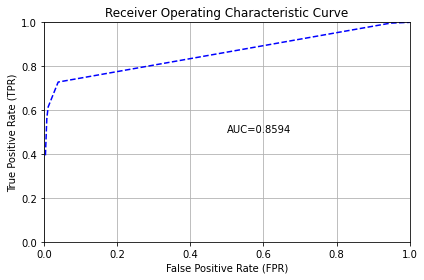

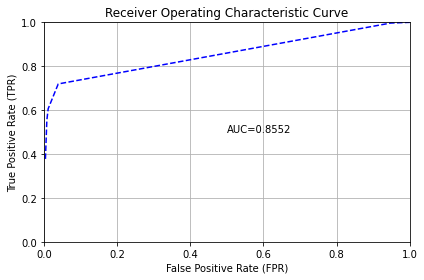

In [42]:
#ROC CURVE: DECISION TREES
DT_test=performance_DT_test.plot(type = "roc")
DT_train=performance_DT_train.plot(type = "roc")

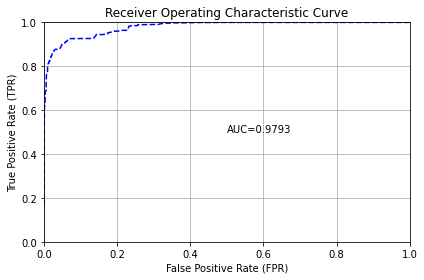

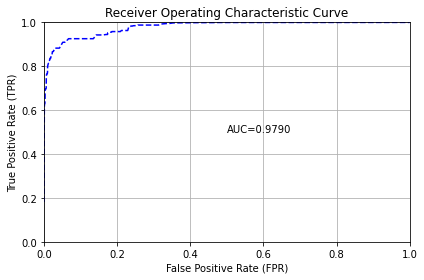

In [43]:
#ROC CURVE: RANDOM FOREST
RF_train=performance_RF_train.plot(type = "roc")
RF_test=performance_RF_test.plot(type = "roc")

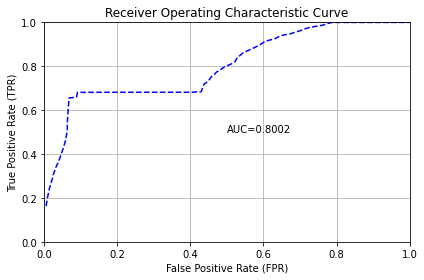

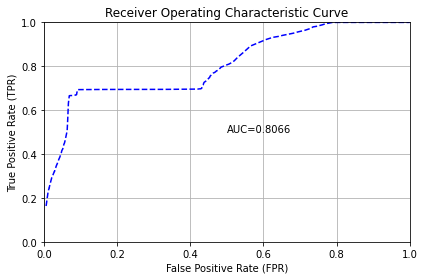

In [44]:
#ROC CURVE: NAIVE BAYES
NV_train=performance_NV_train.plot(type = "roc")
NV_test=performance_NV_test.plot(type = "roc")

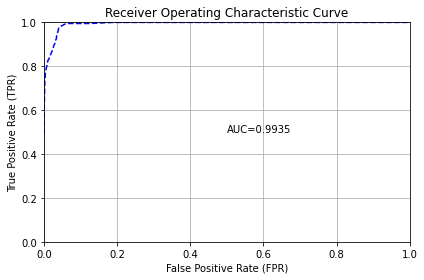

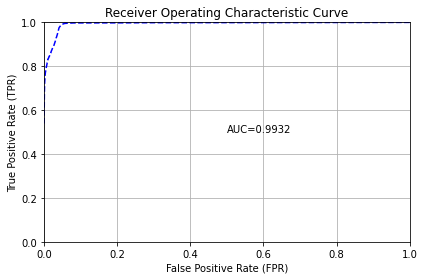

In [45]:
#ROC CURVE: NEURAL NETWORKS
NN_train=performance_NN_train.plot(type = "roc")
NN_test=performance_NN_test.plot(type = "roc")

### Comment: After analyzing the evaluation parameters: Accuracy, sensitivity, specificity, AUC and ROC curve, the best model obtained is: "NEURONAL NETWORKS".